In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.7 MB/s 
     |████████████████████████████████| 77 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 32.5 MB/s 
     |████████████████████████████████| 6.6 MB 34.3 MB/s 
     |████████████████████████████████| 895 kB 32.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


1. Create multmiodal dataloader for this
2. Create a CNN-LSTM that can train and inference
3. Add gradcam and all other stuff

In [2]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import shutil
from PIL import Image
import tqdm
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import vgg19, resnet18, densenet161

import transformers
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW, SGD, Adam

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import pickle

In [3]:
# Global Path Vairables
ROOT_DIR =  "drive/MyDrive/11877-AMMML/dataset/"
DATASET_DIR = ROOT_DIR

In [30]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 1e-4 # 0.001
HIDDEN_DIM = 64 # 64
N_LAYERS = 8 # 2
EPOCHS = 15
CLIP = 5
DROPOUT = 0.1
BATCH_SIZE = 4

In [31]:
dataset = pickle.load(open(DATASET_DIR + 'collaged_MNIST.p','rb'))

Image label is 0.0
Image text is [4 0 0 5]


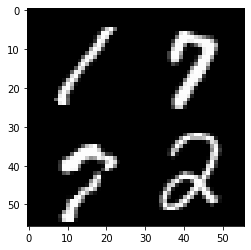

In [32]:
index = 2
image_bytes = dataset["image"][index]
plt.imshow(image_bytes, cmap=plt.cm.gray)
print("Image label is", dataset["label"][index])
print("Image text is", dataset["text"][index])

In [33]:
class MultimodalMnistDataset(Dataset):
  """Dataset containing pairs of MNIST collaged images and text descriptions."""
  def __init__(self, images, texts, labels):
    super(MultimodalMnistDataset, self).__init__()
    self.images = [np.expand_dims(img.astype(np.float32) / 255, 0) for img in images]
    self.texts = texts
    self.labels = labels
  
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.images[idx], self.texts[idx], self.labels[idx]


In [34]:
# texts = [" ".join(list(map(str, x.tolist()))) for x in dataset["text"]]
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(texts)

# tokenized_texts = tokenizer.texts_to_sequences(texts)
# tokenized_texts = pad_sequences(tokenized_texts, maxlen=4)
mnist_dataset = MultimodalMnistDataset(dataset["image"],
                                       dataset["text"],
                                       dataset["label"])
mnist_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE)

In [35]:
class MultimodalMnistClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_hidden, n_layers, n_out):
    super(MultimodalMnistClassifier, self).__init__()
    # LSTM
    self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
    self.emb = nn.Embedding(vocab_size, embedding_dim)
    self.emb.weight.requires_grad = True
    self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
    self.dropout = nn.Dropout(0.1)
    self.lstm_fc = nn.Linear(self.n_hidden, 128)

    # CNN
    self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
    self.conv2 = nn.Sequential(         
        nn.Conv2d(16, 32, 5, 1, 2),     
        nn.ReLU(),                      
        nn.MaxPool2d(2),                
    )

    self.conv3 = nn.Sequential(         
        nn.Conv2d(32, 64, 5, 1, 2),     
        nn.ReLU(),                      
        nn.MaxPool2d(2),                
    )

    self.conv4 = nn.Sequential(         
        nn.Conv2d(64, 32, 3, 1, 2),     
        nn.ReLU(),                      
        nn.MaxPool2d(2),                
    )
    # Concat
    self.combined_fc = nn.Linear(640, 128)
    self.output_fc = nn.Linear(128, n_out)

  def lstm_encoder(self, lstm_inp):
    batch_size = lstm_inp.size(0)
    hidden = self.init_hidden(batch_size)
    lstm_inp = lstm_inp.long()
    embeds = self.emb(lstm_inp)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = self.dropout(lstm_out[:, -1])
    lstm_out = F.relu(self.lstm_fc(lstm_out))
    return lstm_out
  
  def cnn_encoder(self, cnn_inp):
    x = self.conv1(cnn_inp)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    cnn_out = x.view(x.size(0), -1)
    return cnn_out

  def forward(self, cnn_inp, lstm_inp):
    cnn_out = self.cnn_encoder(cnn_inp)
    lstm_out = self.lstm_encoder(lstm_inp)
    combined_inp = torch.cat((cnn_out, lstm_out), 1)
    x_comb = F.relu(self.combined_fc(combined_inp))
    x = self.output_fc(x_comb)
    # x = torch.sigmoid(x)
    return x

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE))
    return hidden

In [36]:
model = MultimodalMnistClassifier(10, 100, HIDDEN_DIM, N_LAYERS, 1)
model.to(DEVICE)
criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [37]:
model.train()
for i in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for cnn, lstm, label in mnist_dataloader:
    lstm_inp, cnn_inp, label = lstm.to(DEVICE), cnn.to(DEVICE), label.to(DEVICE)
    model.zero_grad()
    output = model(cnn_inp, lstm_inp)
    loss = criterion(torch.round(torch.sigmoid(output.squeeze())), label.float())
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - label.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_train += acc.item()
      total_loss_train += loss.item()
  print("Accuracy", total_acc_train / len(mnist_dataloader))
  print("Loss", total_loss_train / len(mnist_dataloader))


Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
Accuracy 0.5
Loss 0.6931471824645996
